In [ ]:
"""author: Vetivert? 💐 
created: 30/04/2025 @ 18:27:50"""

# LOAD DATA

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.preprocessing import StandardScaler, label_binarize 
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, make_scorer 
from sklearn.ensemble import RandomForestClassifier 
from scipy.stats import randint, uniform 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
from src.utils.functions import *

In [ ]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.4, '2': 39.66, '3': 3.94}


# DISTRIBUTION OF EACH COL

In [3]:
# df = df[['ALT1','ALT2','ALT3','ALT4','ALT5','ALT6','ALT7','ALT8','ALT9','AST1','AST2','AST3','AST4','AST5','AST6','AST7','AST8','AST9','PLT1','PLT2','PLT3','PLT4','PLT5','PLT6','PLT7','PLT8','PLT9','Diagnosis']]

df = df.apply(pd.to_numeric, errors='coerce')

In [32]:
x = df['PLT1'].fillna(0)
y = df['PLT2'].fillna(0)
print(len(y))
print(len(x))

for i in range(len(y)):
    if y.loc[i] == 0 or x.loc[i] == 0:
        y = y.drop(i)
        x = x.drop(i)

print(len(y))
print(len(x))

406
406
10
10


79     54.0
160     NaN
254    16.0
259     2.0
301     NaN
318    87.0
320     NaN
326    48.0
327     NaN
333    13.0
345     NaN
347     NaN
348    12.0
393     NaN
395    12.0
405    12.0
Name: PLT5, dtype: float64


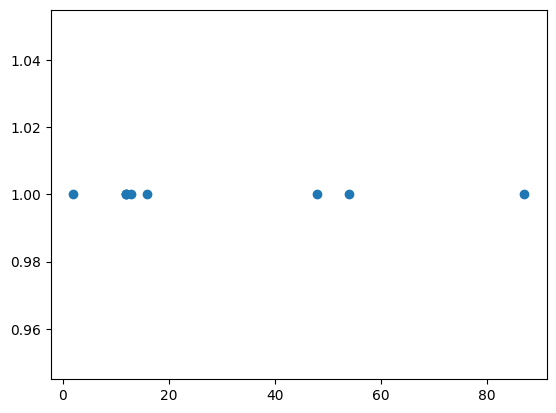

In [13]:
print(df.loc[df['Diagnosis'] == 3, 'PLT5'])

plt.plot(df.loc[df['Diagnosis'] == 3, 'PLT5'], [1] * len(df.loc[df['Diagnosis'] == 3, 'PLT5']), 'o')
plt.show()


In [12]:
def distribution_plot(df_x, x_name: str):
    plt.subplots(figsize=(10, 6))
    x_3 = df_x.loc[df_x['Diagnosis'] == 3, x_name]
    x_2 = df_x.loc[df_x['Diagnosis'] == 2, x_name]
    x_1 = df_x.loc[df_x['Diagnosis'] == 1, x_name]
    y_3 = np.random.rand(x_3.shape[0])
    y_2 = np.random.rand(x_2.shape[0])
    y_1 = np.random.rand(x_1.shape[0])

    # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

    # ax[0].scatter(x_3, np.random.rand(x_3.shape[0]) * 10, color='red', alpha=0.75)
    # ax[0].scatter(x_2, np.random.rand(x_2.shape[0]) * 10, color='navy', alpha=0.75)
    # ax[0].scatter(x_1, np.random.rand(x_1.shape[0]) * 10, color='green', alpha=0.75)
    # ax[0].set_xlabel(x_name + ' Values')
    # ax[0].set_xlim(0, np.max(df_x[x_name]) + 1)
    # ax[0].set_ylim(-0.25, 10.25)
    # ax[0].set_yticks([])

    plt.scatter(x_3, [4/80] * (y_3 + 1), label = 'Diagnosis 3', color='red', alpha=0.65)
    plt.scatter(x_2, [2/80] * (y_2 + 1), label = 'Diagnosis 2',color='navy', alpha=0.65)
    plt.scatter(x_1, [1/80] * (y_1 + 1), label = 'Diagnosis 1',color='green', alpha=0.65)
    plt.vlines(np.max(x_3), 0, (4/80) * (y_3[np.argmax(x_3)]+1), label = f'{np.max(x_3)}: max value of Diagnosis 3', color='red', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_3), 0, (4/80) * (y_3[np.argmin(x_3)]+1), label = f'{np.min(x_3)}: min value of Diagnosis 3', color='red', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_2), 0, (2/80) * (y_2[np.argmax(x_2)]+1), label = f'{np.max(x_2)}: max value of Diagnosis 2', color='navy', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_2), 0, (2/80) * (y_2[np.argmin(x_2)]+1), label = f'{np.min(x_2)}: min value of Diagnosis 2', color='navy', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_1), 0, (1/80) * (y_1[np.argmax(x_1)]+1), label = f'{np.max(x_1)}: max value of Diagnosis 1', color='green', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_1), 0, (1/80) * (y_1[np.argmin(x_1)]+1), label = f'{np.min(x_1)}: min value of Diagnosis 1', color='green', alpha=0.65, linestyle=":")
    sns.kdeplot(x_3, color='red')
    sns.kdeplot(x_2, color='navy')
    sns.kdeplot(x_1, color='green')
    plt.legend()
    # plt.xlim(-10, np.max(df_x[x_name]) + 100)
    plt.yticks([])
    plt.title(x_name + ' Distribution by Diagnosis', fontsize=14)
    # plt.colorbar(ticks = [1,2,3], values = [1,2,3], label='Diagnosis')

    # fig.colorbar(cmap=['green','navy','red'], ticks = [1,2,3], values = [1,2,3], ax = ax[0], label='Diagnosis')
    # fig.suptitle(x_name + ' Distribution by Diagnosis', fontsize=16)
    plt.show()

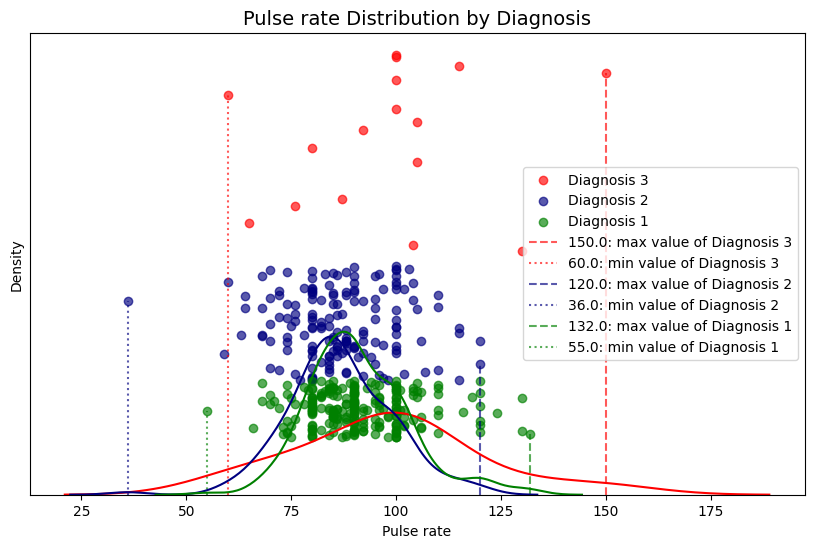

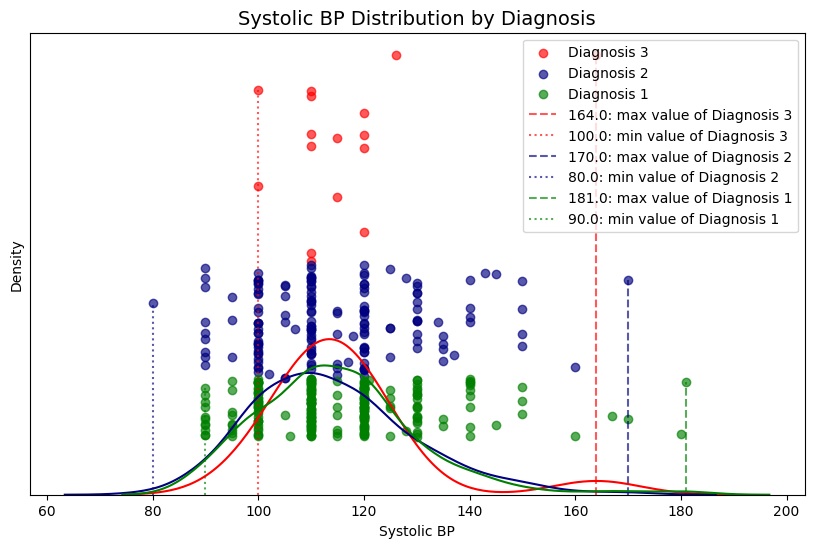

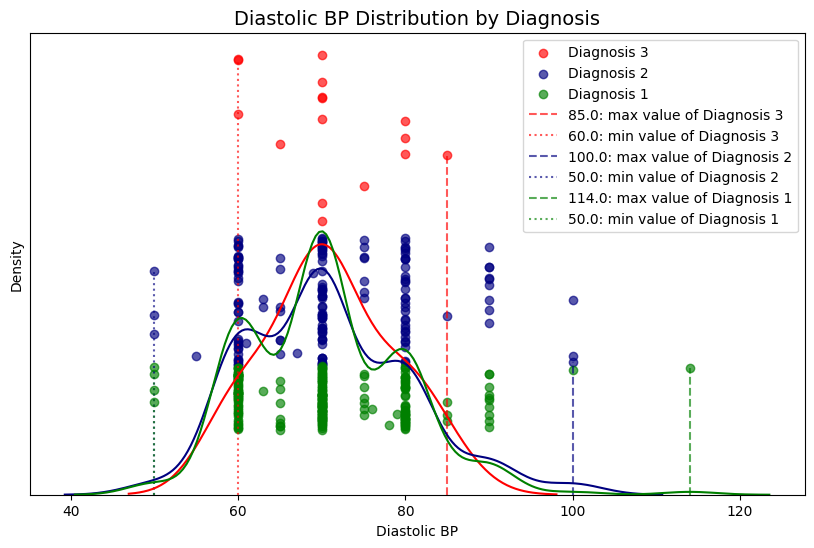

In [13]:
distribution_plot(df, 'Pulse rate')
distribution_plot(df, 'Systolic BP')
distribution_plot(df, 'Diastolic BP')

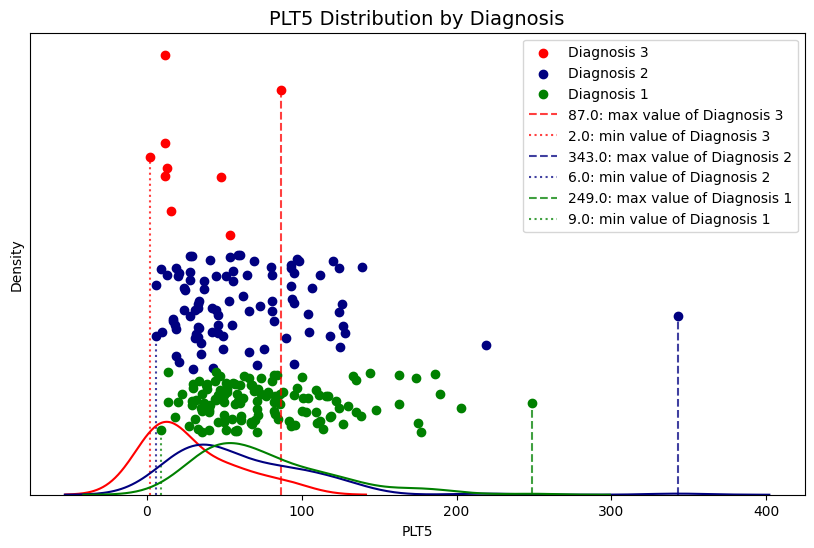

In [153]:
distribution_plot(df, 'PLT5')

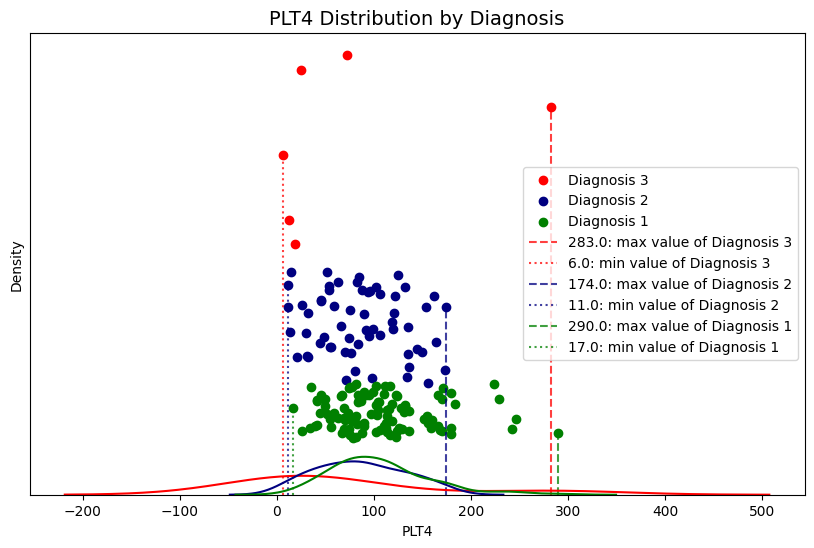

In [154]:
distribution_plot(df, 'PLT4')

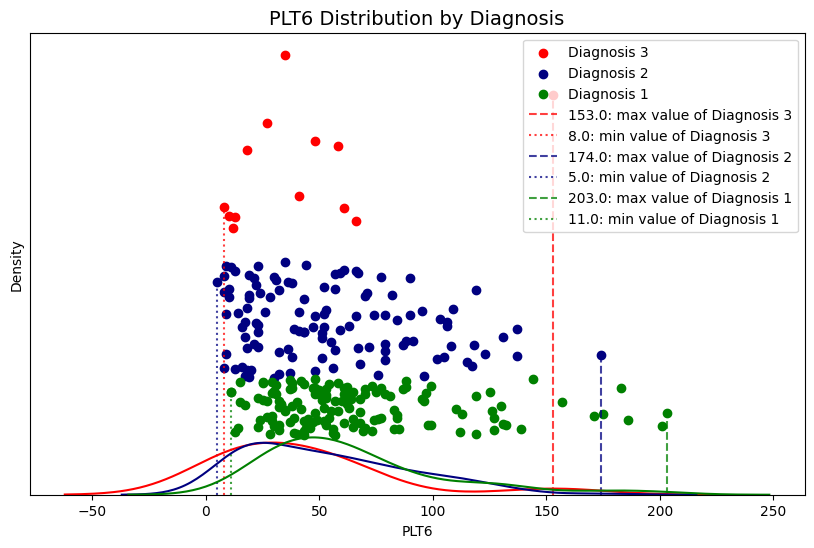

In [155]:
distribution_plot(df, 'PLT6')

/tmp/ipykernel_71811/2152766895.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x_3, color='red')


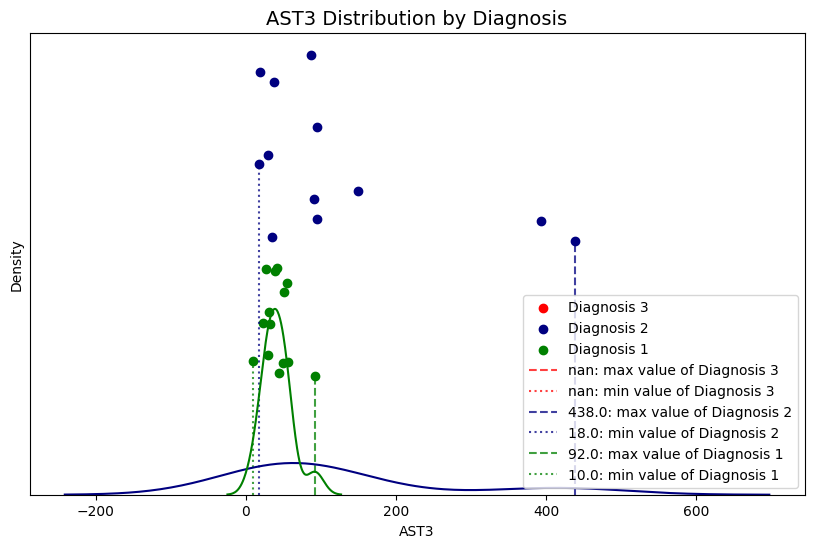

In [156]:
distribution_plot(df, 'AST3')

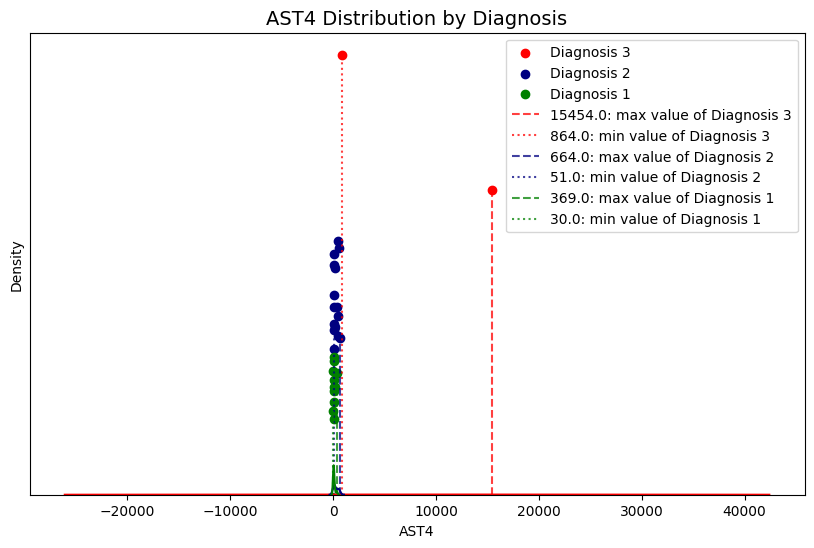

In [157]:
distribution_plot(df, 'AST4')

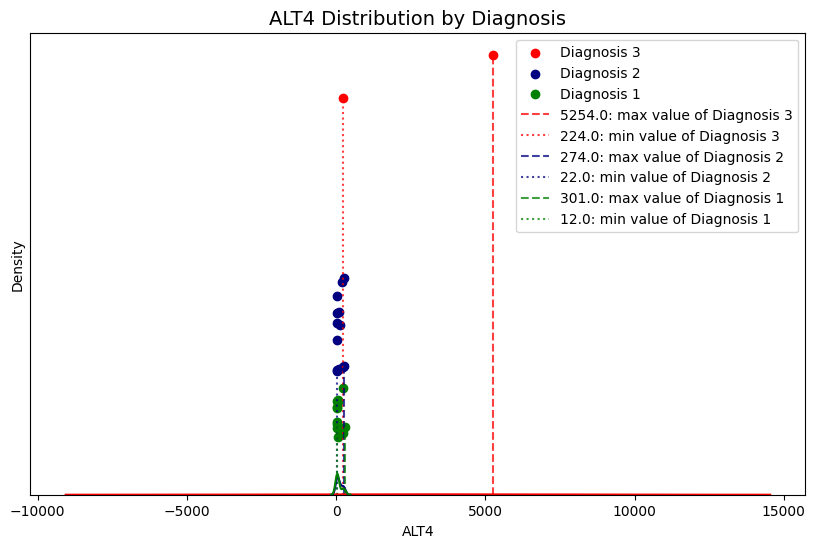

In [158]:
distribution_plot(df, 'ALT4')

/tmp/ipykernel_71811/2152766895.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x_3, color='red')


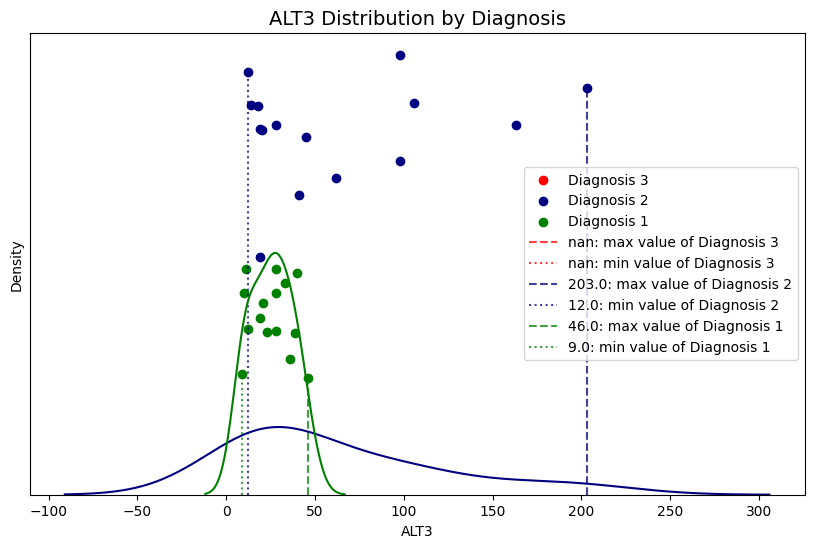

In [159]:
distribution_plot(df, 'ALT3')

# REGRESSION OF PAIRS

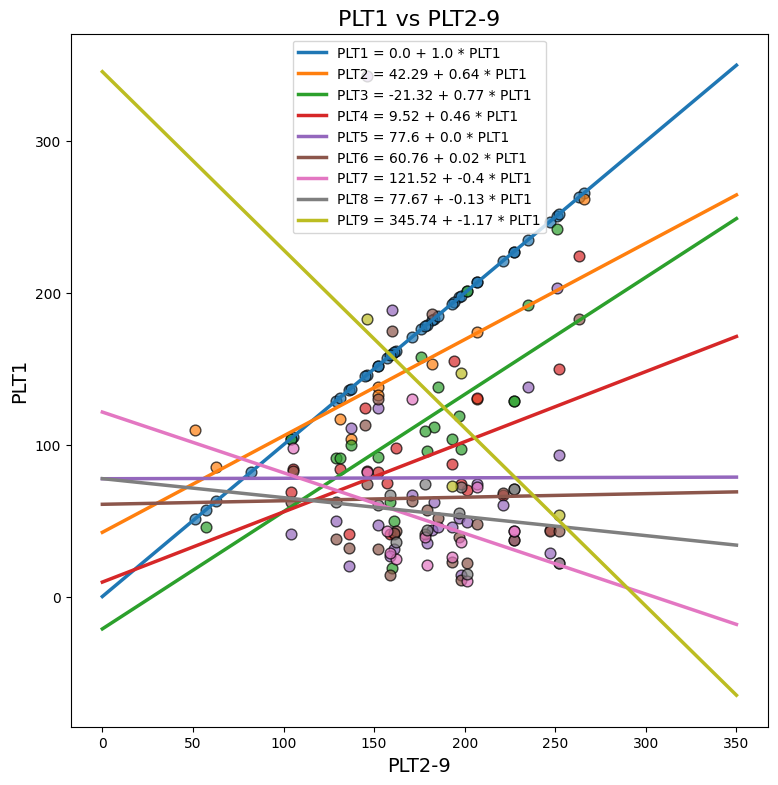

In [161]:
# Initialize layout
fig, ax = plt.subplots(figsize=(9, 9))
for j in range(9):
    y_PLT = 'PLT' + str(j+1)
    # x = df['PLT1'].fillna(np.mean(df['PLT1']))
    # y = df[y_PLT].fillna(np.mean(df[y_PLT]))
    x = df['PLT1'].fillna(0)
    y = df[y_PLT].fillna(0)
    for i in range(len(y)):
        if y.loc[i] == 0 or x.loc[i] == 0:
            y = y.drop(i)
            x = x.drop(i)

    # Add scatterplot
    ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to 100
    xseq = np.linspace(0, 350, num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, lw=2.5, label = f'PLT{j+1} = {np.round(a, 2)} + {np.round(b, 2)} * PLT1')
plt.title('PLT1 vs PLT2-9', fontsize=16)
plt.ylabel('PLT1', fontsize=14)
plt.xlabel('PLT2-9', fontsize=14)
plt.legend()
plt.show()

0
0


TypeError: expected non-empty vector for x

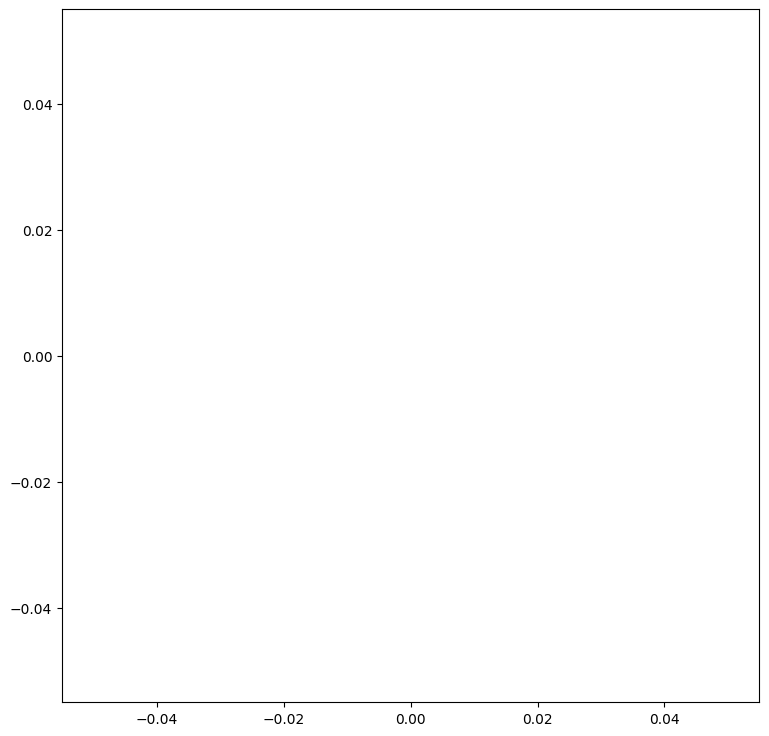

In [83]:
# Initialize layout
fig, ax = plt.subplots(figsize=(9, 9))
for j in range(9):
    y_AST = 'AST' + str(j+1)
    # x = df['PLT1'].fillna(np.mean(df['PLT1']))
    # y = df[y_PLT].fillna(np.mean(df[y_PLT]))
    x = df['AST2'].fillna(0)
    y = df[y_AST].fillna(0)
    for i in range(len(y)):
        if y.loc[i] == 0 or x.loc[i] == 0:
            y = y.drop(i)
            x = x.drop(i)
    print(len(y))
    print(len(x))
    # Add scatterplot
    ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to 100
    xseq = np.linspace(0, 350, num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, lw=2.5, label = f'PLT{j+1} = {np.round(a, 2)} + {np.round(b, 2)} * PLT1')

plt.legend()
plt.show()

# FINAL MODEL

In [3]:
df_symptoms = df[['Gende', 'DHF infection His.', 'additional_diseases', 'Bleeding',
       'Fatigue', 'Rash', 'hematoma', 'Vomiting', 'Abdominal pain or tendness',
       'Liver enlargement']]
df_diagnosis = df[['Diagnosis']]

df_symptoms = df_symptoms.apply(pd.to_numeric, errors='coerce')
df_diagnosis = df_diagnosis.apply(pd.to_numeric, errors='coerce')
df_symptoms = df_symptoms.fillna(0)


In [106]:
# Sample data
X = df_symptoms.values
Y = df_diagnosis.values.ravel()

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

rf_model = RandomForestClassifier()

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

Cross-validated accuracy scores: [0.6097560975609756, 0.6585365853658537, 0.6585365853658537, 0.6341463414634146, 0.6829268292682927, 0.7560975609756098, 0.775, 0.7, 0.55, 0.75]
Mean accuracy: 0.6775


In [129]:
Y = np.where(Y == 3, 2, Y)
print(Y)

[2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1
 2 1 2 1 2 2 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 2 2
 2 2 1 1 1 2 1 2 1 2 1 1 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 1 1 2 1 2 1 1 1 2 1
 1 1 1 2 2 1 2 1 1 1 2 2 2 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 2 2 2 1 1 1 1 1 1
 1 1 1 1 2 2 2 1 2 2 1 1 2 1 1 2 1 1 2 2 2 2 1 2 2 1 2 2 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 1 1 1 1 1
 1 1 1 2 1 1 1 1 2 1 1 1 2 1 2 2 1 1 1 1 2 2 2 1 1 1 2 1 1 1 1 2 2 2 1 1 1
 2 1 1 2 1 2 2 1 2 1 2 2 2 1 1 2 2 2 1 2 1 2 2 2 2 2 2 1 2 1 1 1 1 2 1 2 1
 1 1 2 1 2 2 1 2 2 2 1 2 1 1 1 1 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 1 2 2 1 2
 2 2 1 2 1 2 2 1 2 1 2 2 2 2 2 2 1 2 2 1 2 1 1 1 2 2 2 2 1 1 1 2 1 2 2 1 1
 1 2 1 1 2 2 1 1 1 1 2 2 2 2 2 2 1 2 1 1 1 2 2 2 2 2 2 1 2 1 1 2 2 1 2 2]


In [130]:
param_grid = {'n_estimators': [50, 75, 100, 200], 'max_depth': [3, 7, 9, 15], 'min_samples_split': [2, 5, 10, 12 ], 'min_samples_leaf': [1, 2, 4,6,8], 'max_features': ['sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.7364024390243902


In [169]:
# final_model_2_classes = grid.best_estimator_
import joblib
RF_2_model = joblib.load('/home/smivys/Sorbonne/108/m2_internship/models/RF_2_classes_model.pkl')
# print(X[0].reshape(1, -1))
X = df_symptoms.values
Y = df_diagnosis.values.ravel()
test_1 = []
test_2 = []
for i in range(len(X)):
    # print(final_model_2_classes.predict(X[i].reshape(1, -1)))
    # print(final_model_2_classes.predict_proba(X[i].reshape(1, -1)))
    test_1.append(RF_2_model.predict_proba(X[i].reshape(1, -1))[0][0])
    test_2.append(RF_2_model.predict_proba(X[i].reshape(1, -1))[0][1])

print(np.mean(test_1))
print(np.mean(test_2))

0.5607369146358636
0.4392630853641363


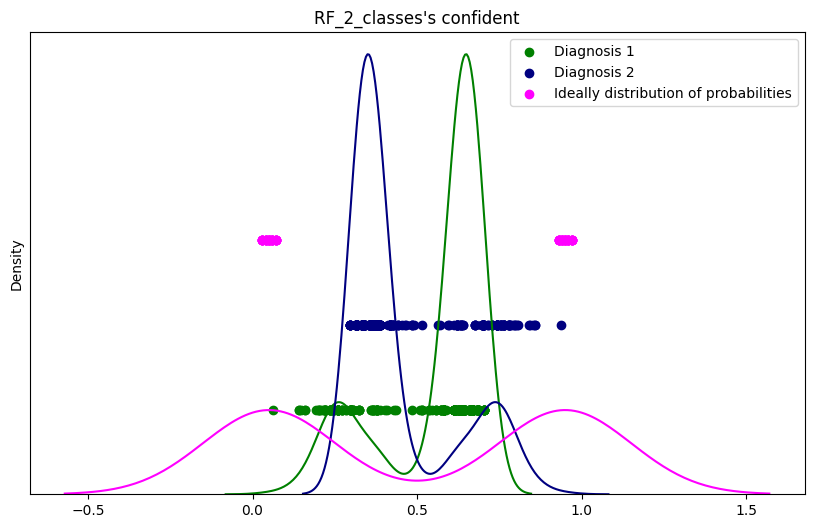

In [182]:
test_ideally = [0.95,0.93,0.94,0.96,0.97, 0.05, 0.03, 0.04, 0.06, 0.07,0.95,0.93,0.94,0.96,0.97, 0.05, 0.03, 0.04, 0.06, 0.07,0.95,0.93,0.94,0.96,0.97, 0.05, 0.03, 0.04, 0.06, 0.07\
                ,0.95,0.93,0.94,0.96,0.97, 0.05, 0.03, 0.04, 0.06, 0.07,0.95,0.93,0.94,0.96,0.97, 0.05, 0.03, 0.04, 0.06, 0.07,0.95,0.93,0.94,0.96,0.97, 0.05, 0.03, 0.04, 0.06, 0.07]

plt.subplots(figsize=(10, 6))
plt.scatter(test_1, [1] * len(test_1), label='Diagnosis 1', color='green')
plt.scatter(test_2, [2] * len(test_2), label='Diagnosis 2', color='navy')
plt.scatter(test_ideally, [3] * len(test_ideally), label='Ideally distribution of probabilities', color='magenta')

sns.kdeplot(test_1, color='green')
sns.kdeplot(test_2, color='navy')
sns.kdeplot(test_ideally, color='magenta')
plt.legend()
plt.yticks([])
plt.title('RF_2_classes\'s confident')
plt.show()

In [176]:
import joblib
# joblib.dump(final_model_2_classes, 'RF_2_classes_model.pkl')
# Later:
RF_model = joblib.load('/home/smivys/Sorbonne/108/m2_internship/models/RF_model.pkl')

0.5660752598631928
0.39233980877593916
0.041584931360867806


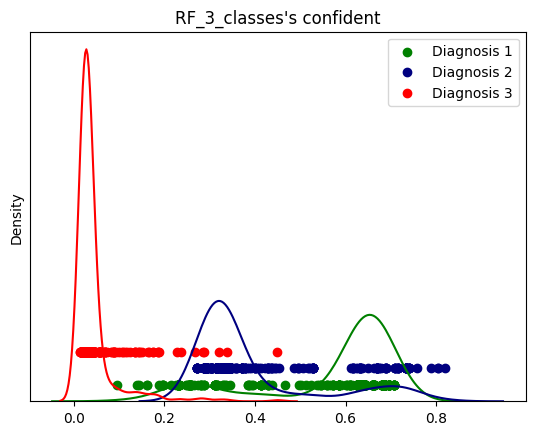

In [183]:
test_3 = []
test_4 = []
test_5 = []
for i in range(len(X)):
    # print(final_model_2_classes.predict(X[i].reshape(1, -1)))
    # print(final_model_2_classes.predict_proba(X[i].reshape(1, -1)))
    test_3.append(RF_model.predict_proba(X[i].reshape(1, -1))[0][0])
    test_4.append(RF_model.predict_proba(X[i].reshape(1, -1))[0][1])
    test_5.append(RF_model.predict_proba(X[i].reshape(1, -1))[0][2])

print(np.mean(test_3))
print(np.mean(test_4))
print(np.mean(test_5))

plt.scatter(test_3, [1] * len(test_3), label='Diagnosis 1', color='green')
plt.scatter(test_4, [2] * len(test_4), label='Diagnosis 2', color='navy')
plt.scatter(test_5, [3] * len(test_5), label='Diagnosis 3', color='red')

sns.kdeplot(test_3, color='green')
sns.kdeplot(test_4, color='navy')
sns.kdeplot(test_5, color='red')
plt.title('RF_3_classes\'s confident')
plt.yticks([])
plt.legend()
plt.show()

In [ ]:
test_6 = []

for i in range(len(X)):
    # print(final_model_2_classes.predict(X[i].reshape(1, -1)))
    # print(final_model_2_classes.predict_proba(X[i].reshape(1, -1)))
    test_6.append(RF_model.predict(X[i].reshape(1, -1))[0])

print(test_6)
print(Y)


[1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [158]:
print(accuracy_score(df_diagnosis.values.ravel(), test_6))
print(df_diagnosis.values.ravel())

0.7118226600985221
[2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1
 2 1 2 1 2 2 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 2 2
 2 2 1 1 1 3 1 2 1 2 1 1 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 1 1 2 1 2 1 1 1 2 1
 1 1 1 2 2 1 2 1 1 1 2 2 2 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 2 2 2 1 1 1 1 1 1
 1 1 1 1 2 2 2 1 2 2 1 1 3 1 1 2 1 1 2 2 2 2 1 2 2 1 2 2 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 1 1 1 1 1
 1 1 1 2 1 1 1 1 2 1 1 1 2 1 2 2 1 1 1 1 2 2 2 1 1 1 2 1 1 1 1 2 3 2 1 1 1
 3 1 1 2 1 2 2 1 2 1 2 2 2 1 1 2 2 2 1 2 1 2 2 2 2 2 2 1 2 1 1 1 1 2 1 2 1
 1 1 2 1 2 3 1 2 2 2 1 2 1 1 1 1 1 1 2 2 1 2 3 2 3 1 2 1 2 2 3 3 1 2 2 1 2
 3 2 1 2 1 2 2 1 2 1 2 2 3 2 3 3 1 2 2 1 2 1 1 1 2 2 2 2 1 1 1 2 1 2 2 1 1
 1 2 1 1 2 2 1 1 1 1 2 2 2 2 2 2 1 2 1 1 1 2 2 3 2 3 2 1 2 1 1 2 2 1 2 3]


# BIAS/VARIANCE check

In [4]:
import joblib
RF_2_model = joblib.load('/home/smivys/Sorbonne/108/m2_internship/models/RF_2_classes_model.pkl')

In [5]:
X = df_symptoms.values
y = df_diagnosis.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

train_preds = RF_2_model.predict(X_train)
test_preds = RF_2_model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.7191358024691358
Test accuracy: 0.6951219512195121


In [11]:
scores = cross_val_score(RF_2_model, X, y, cv=5)
print(f"Cross-validated scores: {scores}")
print(f"Mean accuracy: {scores.mean()} ± {scores.std()}")

Cross-validated scores: [0.64634146 0.66666667 0.74074074 0.67901235 0.72839506]
Mean accuracy: 0.6922312556458898 ± 0.03631845766537298


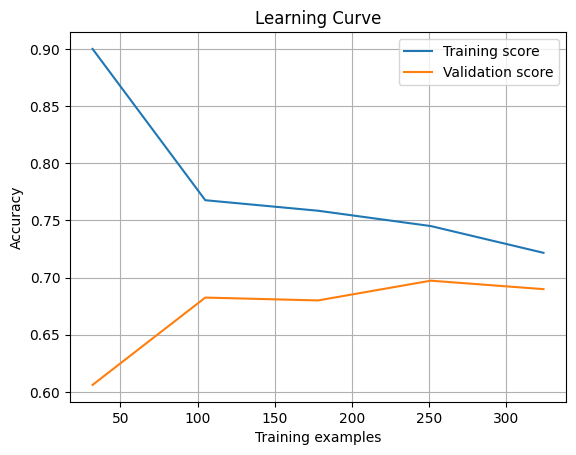

In [ ]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores, _, _ = learning_curve(RF_2_model, X, y, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Validation score")
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid()
plt.show()